In [1]:
import os
import sys

### FOR CLALIT
# who_str = 'ayyake'
# sys.path.append(f'/home/{who_str}/workspace/repo/cutils/')
# sys.path.append(f'/home/{who_str}/workspace/repo/childhood_obesity/')
# sys.path.append(f'/home/{who_str}/workspace/repo/birth_projects/src/')
# sys.path.append(f'/home/{who_str}/workspace/repo/birth_projects/src/utils')

data_path = os.path.join('data','nhefs.csv')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

from Survival_Analysis import Survival_Analysis

# from DEFS_BIRTH_PROJECTS import DAYS_IN_YEAR
DAYS_IN_YEAR = 365.25

# Load and prepare NHFES data

Available for download at https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv

In [3]:
from survival_utils.nfhes_data_prep import prepare_nhfes_surv_data


## Defs
months_bins=1

pscore_col = 'pscore'
weights_col = 'IPW'
id_col = 'seqn'
index_time_col = 'index_date'
TX_col = 'qsmk'
outcome_time_col = 'date_death'
outcome_event_col = 'death'
ps_cols = ['one', 'sex', 'race', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'exercise_1', 'exercise_2', 'active_1', 'active_2',
            'age', 'age_sqr', 'wt71', 'wt71_sqr','smokeintensity', 'smokeintensity_sqr', 'smokeyrs', 'smokeyrs_sqr']

outcome_name='Death'
TX_labels_dict = {0:'Did not quit smoking', 1:'Quit smoking'}
TX_colors = {0:'royalblue', 1:'darkorange'}

followup_end_time = -int(7*DAYS_IN_YEAR) +1 
followup_max_time_from_index = int(10*DAYS_IN_YEAR) + 1
followup_max_time_from_index_binned = int(10*(12/months_bins)) + 1

# load and prepare data
nhefs_all = prepare_nhfes_surv_data(data_path)

nhefs_all[index_time_col] = -(17*DAYS_IN_YEAR)
nhefs_all[outcome_time_col] = ((nhefs_all['yrdth']-100)*DAYS_IN_YEAR + nhefs_all['modth']*(DAYS_IN_YEAR/12))
nhefs_all[outcome_time_col] = nhefs_all[outcome_time_col].fillna(followup_max_time_from_index)
data = nhefs_all.dropna(subset=['qsmk'])[ps_cols + [index_time_col, outcome_time_col, outcome_event_col, 
                                                    pscore_col, weights_col, TX_col, id_col]].copy()
data.head(2)

Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6


,one,sex,race,edu_2,edu_3,edu_4,edu_5,exercise_1,exercise_2,active_1,...,smokeintensity_sqr,smokeyrs,smokeyrs_sqr,index_date,date_death,death,pscore,IPW,qsmk,seqn
0,1,0,1,0,0,0,0,0,1,0,...,900,29,841,-6209.25,3653.0,0,0.108998,0.827453,0,233
1,1,0,0,1,0,0,0,0,0,0,...,400,24,576,-6209.25,3653.0,0,0.148886,0.866232,0,235


In [4]:
data_lr = data.drop([outcome_time_col], axis=1)
outcome = data[[id_col, outcome_time_col]]
ps_df = data[[pscore_col, weights_col, id_col] + ps_cols]

# Initialize class

In [5]:
survival_analysis = Survival_Analysis(data, outcome, outcome_time_col, 'Death', id_col, index_time_col, TX_col, 
                                      TX_labels_dict, TX_colors, followup_end_time, followup_max_time_from_index, 
                                      months_bins, ps_df, pscore_col, ps_cols, weights_col, n_bootstraps=5)

# Fit and plot a LR model

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


Difference in survival probability at time 120: 5.4% (3.7, 9.3)


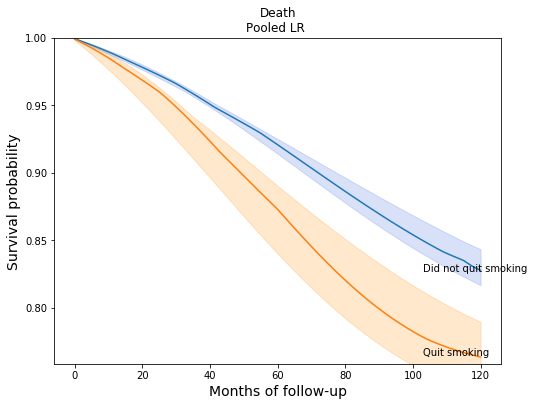

In [6]:
survival_analysis.estimate_survival(method='LR')
survival_analysis.plot_survival()
survival_analysis.survival_difference(120)

# Fit and plot IPW LR model

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


Difference in survival probability at time 120: 0.2% (-1.9, 2.1)


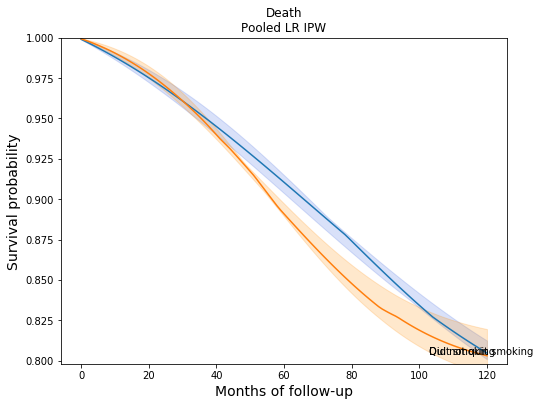

In [7]:
survival_analysis.estimate_survival(method='IPW')
survival_analysis.plot_survival()
survival_analysis.survival_difference(120)

# Fit and plot LR Standardization model - sklearn

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

NUMERIC_FEATURES = ['age', 'age_sqr', 'wt71','smokeintensity', 'smokeintensity_sqr', 'smokeyrs', 'smokeyrs_sqr'] # dropped  'wt71_sqr'

numeric_transformer = Pipeline(steps=[('std', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, NUMERIC_FEATURES)], remainder='passthrough')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.05s/it]

Difference in survival probability at time 120: 0.9% (-0.6, 2.0)


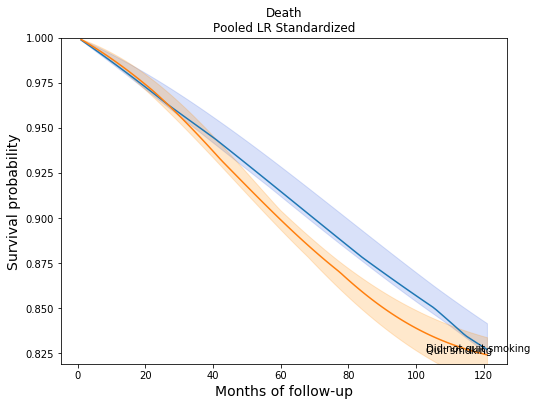

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='none', solver='lbfgs', max_iter=5000)
# model = GradientBoostingClassifier(n_estimators=1000)

survival_analysis.estimate_survival('STANDARDIZE', model, preprocessor, NUMERIC_FEATURES)
survival_analysis.plot_survival()
survival_analysis.survival_difference(120)